<img style="float: left;" src="icon.jpg">
<img style="float: right;" src="https://www.tudublin.ie/media/website/site-assets/images/tu-dublin-logo-blue.svg">

<br><br><br><br>

# Eye of Another World :: Weapon Visualizer


by  <a href="mailto:X00193937@mytudublin.ie">Jorge Jimenez Garcia</a> 


## Sections:
* <a href="#dep_and_prereq"> Dependencies, Imports, Prerequisites and Global Configs </a>
* <a href="#prelude">Prelude </a>
* <a href="#visualization"> Visualization </a>
    * <a href="#usage stats"> Usage Statistics </a>
    * <a href="#density"> Density plots </a>

<a name="dep_and_prereq"> </a>
## Dependencies, Imports, Prerequisites and Global Configs

In [83]:

# IMPORTS-------------------------
import sqlite3
from collections import Counter
import ctypes
import pickle
import json
import zipfile
import requests
import os
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

# CONSTANTS-----------------------------
BNET_URL = 'http://Bungie.net'
MANIFEST_SUFFIX = '/Platform/Destiny2/Manifest/'
WEAPON_SLOT_NAMES = ['', 'Primary', 'Special', 'Power']

PROPERTIES_QUERY = """
SELECT json_extract(json, '$.displayProperties.name'), json_extract(json, '$.inventory.tierTypeName'), json_extract(json, '$.itemTypeDisplayName'), json_extract(json, '$.equippingBlock.ammoType'), json_extract(json, '$.sockets'), json_extract(json, '$.stats.stats')
FROM DestinyInventoryItemDefinition
WHERE id == {}
"""
FRAME_NAME_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE id == {}
"""

PERK_SET_QUERY = """
SELECT json_extract(json, '$.reusablePlugItems')
FROM DestinyPlugSetDefinition
WHERE id == {}
"""

PERK_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE id == {} AND json_extract(json, '$.itemTypeDisplayName') == 'Trait'
"""

ALL_PERKS_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition
WHERE json_extract(json, '$.itemTypeDisplayName') == 'Trait'
"""

HASH_STABILITY = str(155624089)
HASH_HANDLING = str(943549884)
HASH_RANGE = str(1240592695)
HASH_AIMASSIST = str(1345609583)
HASH_AIRBORNEEFF = str(2714457168)
HASH_RECOILDIR = str(2715839340)
HASH_ZOOM = str(3555269338)
HASH_MAGSIZE = str(3871231066)
HASH_IMPACT = str(4043523819)
HASH_RELOAD = str(4188031367)
HASH_RPM = str(4284893193)

# Specific stats to certain weapon types

HASH_FR_CHARGETIME = str(2961396640)

#bows have chargetime? id == to fusion chargetime, but the stat is always 0?
HASH_BOW_DRAWTIME = str(447667954) # ~rpm?
HASH_BOW_ACCURACY = str(1591432999)

HASH_RLGL_VELOCITY = str(2523465841)
HASH_RLGL_BLASTRADIUS = str(3614673599)

HASH_GLAIVE_SHIELDDUR = str(1842278586)

HASH_SWORD_GUARDRES = str(209426660)
HASH_SWORD_GUARDEFF = str(2762071195)
HASH_SWORD_SWINGSPEED = str(2837207746) # ~rpm?
HASH_SWORD_CHARGERATE = str(3022301683)

# Socket constants

HASH_SOCKET_WEAPONPERK = 4241085061


_Config settings:_


#### `CONFIG__DF_IGNORE_EXOTICS`: Why leave out Exotic weapons?

Exotic weapons are the stand out in a players arsenal. Unique in their behaviour, they would be useless data in our study, since they have traits generally exclusive to them, and so including them in our pool of analyzed traits does not help us predict the popularity of gear, because no other item will have those traits

#### `CONFIG__DATA_FILE_NAME`:

File name to load and process as a dataFrame

In [3]:
# CONFIG----------------------------
CONFIG__DF_IGNORE_EXOTICS = True
CONFIG__DATA_FILE_NAME = 'RAD2MODE70-from2022-09-23-to2022-10-03' # Big pre-Oct 18th patch dataset
#CONFIG__DATA_FILE_NAME = 'RAD2MODE70-from2022-09-23-to2022-10-24'

#CONFIG__PLT_SIZE
plt.rcParams['figure.figsize'] = [6, 6]

# Force reload of the dataframe
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([6])")

<IPython.core.display.Javascript object>

<a name="prelude" > </a>
## Prelude

### Data Set construction

#### Chosen attributes

Across the several weapon categories, items have different sets of stats, to the point where some categories will have stats only found for that category. For the meantime, they are ketp in the dataset and filled out as NaN for items where the stat is not applicable or meaningless.


<br><br>



___NOTE___: __This preliminary dataset does not contain perk data__, perks are properties of weapons that alter their stats, behaviour, expand their functionality, or a combination of the above. __Perks are randomly selected for a pool of possible choices set for a weapon, and generally each weapon has two of them.__

In the API, these are represented as a list of the hashes of these possible perks. Since it is out of our scope to convey how each perk affects a weapon, __we would like to keep the possible set as a feature__, with the hypothesis that the possibility of certain perks appearing on a weapon is one of the key factors that boost their popularity. _However_, for the meantime, how we would represent this in the dataframe is unclear.

OHE TO REPRESENT PERK DATA

In [100]:

# Read data file
with open(CONFIG__DATA_FILE_NAME + '.d2data', 'rb') as f:
    (weaponFreq, gameSet) = pickle.load(f)
    print('Loaded dataSet: {} weapon instances ({} unique) across {} unique games.'.format(sum(weaponFreq.values()), len(weaponFreq.keys()), len(gameSet)))
    if CONFIG__DF_IGNORE_EXOTICS:
        print('[INFO]: Config::IgnoreExotics is set: Some instances will be ignored')

# Check Manifest, and update if needed
try:
    manifests = requests.get(BNET_URL + MANIFEST_SUFFIX).json()
    manifest_location = manifests['Response']['mobileWorldContentPaths']['en']
except KeyError:
    # Sometimes an error is returned saying the endpoint needs authorization, but it doesn't need it? 
    # just retry
    print('Server did not respond: ', manifests['ErrorStatus'], ':', manifests['Message'])
    raise RuntimeError
DB_NAME = manifest_location[35:]
if not os.path.exists(DB_NAME):
    print('{} not found: Downloading Destiny Manifest, this may take a while...'.format(DB_NAME))
    manifest_zip = requests.get(BNET_URL + manifest_location).content
    print('Up-to-date Manifest downloaded:')
    with zipfile.ZipFile(BytesIO(manifest_zip)) as z:
        with open(DB_NAME, 'wb') as f:
            f.write(z.read(DB_NAME))
else:
    print('Manifest found at {}'.format(DB_NAME))


db = sqlite3.connect(DB_NAME).cursor()

name_l = []
weaponid = []
weapon_type = []
weapon_archetype = []
weapon_slot = []
usage_absolute = []
usage_rate = []
usage_rate_slot = []


# Stats
stability = []
handling = []
rang = []
aim_assist = []
airborne_effectiveness = []
recoil_direction = []
zoom = []
magsize = []
impact = []
reload = []
rpm = []

bow_drawtime = []
bow_accuracy = []
fr_chargetime = []
rlgl_velocity = []
rlgl_blastradius = []
glaive_shieldduration = []
sword_guardresistence = []
sword_guardefficiency = []
sword_swingspeed = []
sword_chargerate = []


stat_arr = [stability,handling,rang,aim_assist,airborne_effectiveness,recoil_direction,zoom,magsize,impact,reload,rpm,bow_drawtime,bow_accuracy,fr_chargetime,rlgl_velocity,rlgl_blastradius,glaive_shieldduration,sword_guardresistence,sword_guardefficiency,sword_swingspeed,sword_chargerate]
stat_hash_arr = [HASH_STABILITY,HASH_HANDLING,HASH_RANGE,HASH_AIMASSIST,HASH_AIRBORNEEFF,HASH_RECOILDIR,HASH_ZOOM,HASH_MAGSIZE,HASH_IMPACT,HASH_RELOAD,HASH_RPM,HASH_BOW_DRAWTIME,HASH_BOW_ACCURACY,HASH_FR_CHARGETIME,HASH_RLGL_VELOCITY,HASH_RLGL_BLASTRADIUS,HASH_GLAIVE_SHIELDDUR,HASH_SWORD_GUARDRES,HASH_SWORD_GUARDEFF,HASH_SWORD_SWINGSPEED,HASH_SWORD_CHARGERATE]

all_perks_list = [ e[0] for e in db.execute(ALL_PERKS_QUERY).fetchall() ]

left_column = {}
right_column= {}
print(len(all_perks_list),'perks in db')
for e in all_perks_list:
    left_column[e] = []
    right_column[e]= []
    
slot_totals = {'Primary': 0, 'Special': 0, 'Power': 0 }
for weaponId, ct in weaponFreq.items():
        name, tier, weaponType, weaponSlot, sockets, stats = db.execute(PROPERTIES_QUERY.format(ctypes.c_int32(weaponId).value)).fetchall()[0]

        weaponSlot = WEAPON_SLOT_NAMES[weaponSlot]
        sockets = json.loads(sockets) # Perks: TODO        
        stats = json.loads(stats)
        
        # Weapon tier filter:
        if tier != 'Exotic':
            frameId = sockets['socketEntries'][0]['singleInitialItemHash']
            frame = db.execute(FRAME_NAME_QUERY.format(ctypes.c_int32(frameId).value)).fetchall()[0][0]
            
            # Unify special frame names THAT DO NOT CHANGE BEHAVIOUR (meaning stuff like Omolon Adaptive for sidearms remains untouched)
            if frame == "Together Forever" or (frame == "Omolon Adaptive Frame" and weaponType != 'Sidearm'):
                frame = "Adaptive Frame"
            elif frame == "MIDA Synergy":
                frame = "Lightweight Frame"
            elif frame == "VEIST Rapid-Fire":
                frame = "Rapid-Fire Frame"
            elif frame == 'Shot Package': # Exception: There *is* a difference here, but it is minimal.
                frame = 'Aggressive Frame'     
        else:
            if CONFIG__DF_IGNORE_EXOTICS:
                continue
            frame = 'Exotic'
            
        # Stats
        for idx, stat_hash in enumerate(stat_hash_arr):
            try:
                stat_arr[idx].append(stats[stat_hash]['value'])
            except KeyError:
                stat_arr[idx].append(-1)
        
        name_l.append(name)
        weaponid.append(weaponId)
        weapon_type.append(weaponType)
        weapon_archetype.append(frame)
        weapon_slot.append(weaponSlot)
        slot_totals[weaponSlot] += ct
        usage_absolute.append(ct)
        
        #print(tier)
        # Non-Legendary/Exotic items do not have perks:
        #if tier not in ['Legendary', 'Exotic']:
        #    continue
        

        # Perks        
        perkindex = []
        #print(name, '//', weaponId)
        for s in sockets['socketCategories']:
            if s['socketCategoryHash'] == HASH_SOCKET_WEAPONPERK:
                perkindex = (s['socketIndexes'])
        #if perkindex == []:
        #    print('Malformed item {} with ID {} had no Weapon Perks!'.format(name, weaponId))
        #    raise RuntimeError
        

        # We only expect 2 columns (l/r). Preselect left, fill and then swap to right
        l_col = []
        r_col = []
        
        selected_column = l_col
        for perk_idx in perkindex:
            slot = sockets['socketEntries'][perk_idx]
            
            # Get the set
            
            # Account for 'curated'/'ritual'/weapons with a set choice of perks
            perk_set_hash = slot[ 'randomizedPlugSetHash' if 'randomizedPlugSetHash' in slot else 'reusablePlugSetHash' ]
            perk_set = db.execute(PERK_SET_QUERY.format(ctypes.c_int32(perk_set_hash).value)).fetchall()
            perk_set = json.loads(perk_set[0][0])
            
            for e in perk_set:
                # Check if the item in the set is of type 'Trait': if not, we are not in a perk column
                perkname = db.execute(PERK_QUERY.format(ctypes.c_int32(e['plugItemHash']).value)).fetchall()
                if perkname == []:
                    break
                selected_column.append(perkname[0][0])
                #print('\t\t',perkname[0][0])
            if selected_column != []:
                selected_column = r_col
            #print()
        
        #assert (l_col != []) or (r_col != [])
        
        # Update the perk vectors
        for k in left_column.keys():
            if k in l_col:
                left_column[k] = left_column[k] + [1]
            else:
                left_column[k] = left_column[k] + [0]
        # HOLD ON! If the item is a Year 1 weapon, it does not have a right column perk
        for k in left_column.keys():
            if k in r_col:
                right_column[k] = right_column[k] + [1]
            else:
                right_column[k] = right_column[k] + [0]
        
        
# Usage data
total_count = sum(usage_absolute)
for i in range(len(weapon_slot)):
    slot = weapon_slot[i]
    uabs = usage_absolute[i]
    urat_slot = uabs / slot_totals[slot]
    urat = uabs / total_count
    
    usage_rate.append( urat * 100 )
    usage_rate_slot.append( urat_slot * 100)
    
print("Generating DataFrame: {} weapons accounted ({} unique)".format(total_count, len(usage_rate)))

df = pd.DataFrame(
    {
        'Name': pd.Series(name_l, dtype='category'),
        'Weapon Type': pd.Series(weapon_type, dtype='category'),
        'Archetype': pd.Series(weapon_archetype, dtype='category'),
        'Slot': pd.Series(weapon_slot, dtype='category'),
        'WeaponID': pd.Series(weaponid, dtype='category'),
        'Stability': stability,
        'Handling': handling,
        'Range': rang,
        'Aim Assistance': aim_assist,
        'Airborne Effectiveness': airborne_effectiveness,
        'Recoil Direction': recoil_direction,
        'Zoom': zoom,
        'Magazine Size': magsize,
        'Impact': impact,
        'Reload Speed': reload,
        'Rounds Per Minute': rpm,
        'Draw Time': bow_drawtime,
        'Accuracy': bow_accuracy,
        'Charge Time': fr_chargetime,
        'Velocity': rlgl_velocity,
        'Blast Radius': rlgl_blastradius,
        'Shield Duration': glaive_shieldduration,
        'Guard Resistance': sword_guardresistence,
        'Guard Efficiency': sword_guardefficiency,
        'Swing Speed': sword_swingspeed,
        'Charge Rate': sword_chargerate,
        'Ocurrences': usage_absolute
        
    }
)

# Get perks that appeared at least once on any column:
appears = []
for k in all_perks_list:
    if sum(right_column.get(k)) + sum(left_column.get(k)) > 0:
        appears.append(k)

# if no perk appears, something has gone horribly wrong
assert appears != []
print(f'{len(appears)} perks detected')

# WARNINGS: pd will constantly complain about performance degradation by adding so many new columns, which
# causes fragmentations. This will later be solved via df.copy() so we disable warnings temporarily

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for k in appears:
    df[k + ' in Right Column'] = pd.Series(right_column.get(k, [0 * len(usage_absolute)]), dtype='category')
    df[k + ' in Left Column'] =  pd.Series(left_column.get(k, [0 * len(usage_absolute)]), dtype='category')
    
assert round(sum(usage_rate),2) == 100.0 # FLOATING POINT VALUES MAN, GREAT
assert round(sum(usage_rate_slot),2) == 300.0

df['Usage Rate in Slot (%)'] = usage_rate_slot
df['Global Usage Rate (%)']  = usage_rate

# Defragment DataFrame
df = df.copy()

# WARNINGS: Re-enable Performance Warnings
warnings.simplefilter(action='default', category=pd.errors.PerformanceWarning)

df.to_csv(CONFIG__DATA_FILE_NAME + '.csv')
#df.sort_values(by = 'Ocurrences', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)
df.tail(20)

Loaded dataSet: 21525 weapon instances (536 unique) across 813 unique games.
[INFO]: Config::IgnoreExotics is set: Some instances will be ignored
Manifest found at world_sql_content_cf5a65c9b321fad0964c84f1468973be.content
248 perks in db
Generating DataFrame: 15000 weapons accounted (442 unique)
149 perks detected


,Name,Weapon Type,Archetype,Slot,WeaponID,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,...,Ambitious Assassin in Right Column,Ambitious Assassin in Left Column,Energy Transfer in Right Column,Energy Transfer in Left Column,Slideways in Right Column,Slideways in Left Column,Eager Edge in Right Column,Eager Edge in Left Column,Usage Rate in Slot (%),Global Usage Rate (%)
422,BrayTech RWP Mk. II,Scout Rifle,High-Impact Frame,Primary,717150101,29,29,70,39,-1,...,0,0,0,0,0,0,0,0,0.013051,0.006667
423,Blue Shift,Rocket Launcher,High-Impact Frame,Power,417474226,58,63,-1,69,3,...,0,0,0,0,0,0,0,0,0.062112,0.006667
424,Reckless Oracle,Auto Rifle,Rapid-Fire Frame,Primary,3385326721,56,42,26,75,10,...,0,0,0,0,0,0,0,0,0.013051,0.006667
425,Oxygen SR3,Scout Rifle,Precision Frame,Primary,3907337522,45,41,44,67,10,...,0,0,0,0,0,0,0,0,0.013051,0.006667
426,Harsh Language,Grenade Launcher,Lightweight Frame,Special,2936850733,29,65,-1,75,-1,...,0,0,0,0,0,0,0,0,0.017458,0.006667
427,Sand Wasp-3au,Auto Rifle,Rapid-Fire Frame,Primary,2351747818,48,40,28,70,-1,...,0,0,0,0,0,0,0,0,0.013051,0.006667
428,A Fine Memorial,Machine Gun,Adaptive Frame,Power,3325778512,37,58,41,61,6,...,0,1,0,0,0,1,0,0,0.062112,0.006667
429,No Turning Back,Combat Bow,Precision Frame,Primary,720351794,48,54,-1,66,10,...,0,0,0,0,0,0,0,0,0.013051,0.006667
430,Holless-IV,Combat Bow,Precision Frame,Primary,3651075426,35,45,-1,58,-1,...,0,0,0,0,0,0,0,0,0.013051,0.006667
431,Uriel's Gift,Auto Rifle,Precision Frame,Primary,3762467076,39,40,57,44,10,...,0,0,0,0,0,0,0,0,0.026103,0.013333


In [104]:
df.loc[ df['Name'] == 'Better Devils' ]

0

<a name="visualization"> </a>
## Visualization

<a name="usage stats"> </a>
#### Usage statistics:

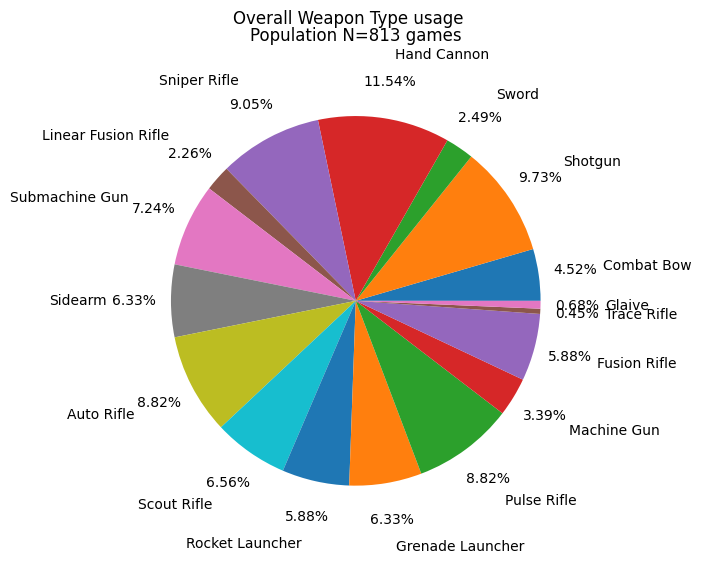

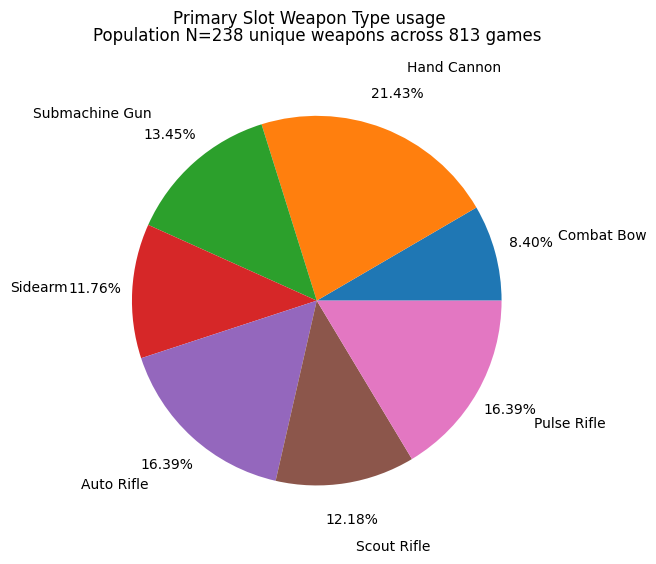

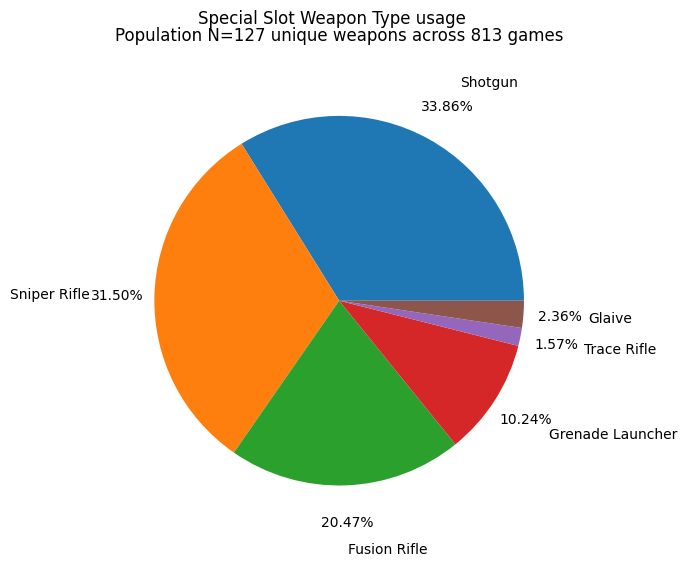

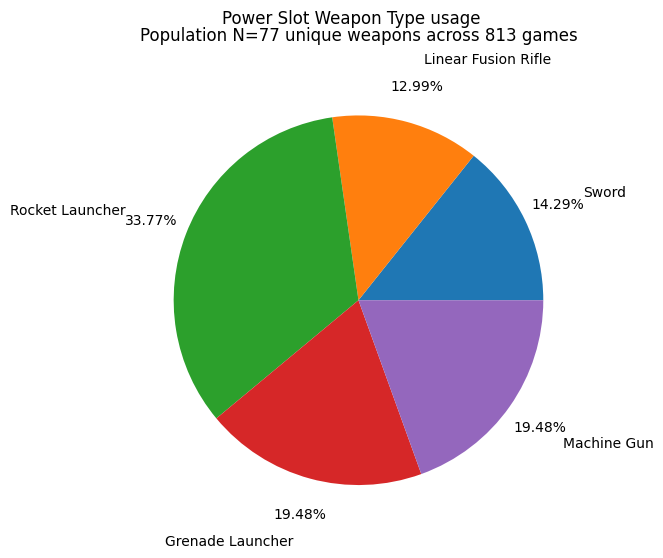

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


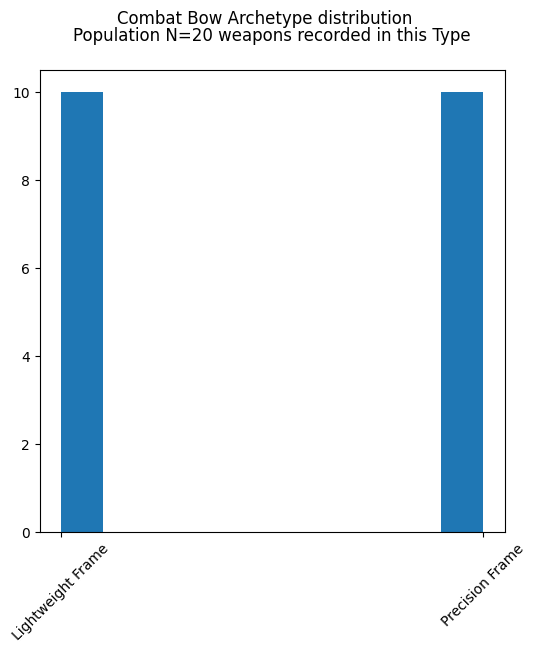

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


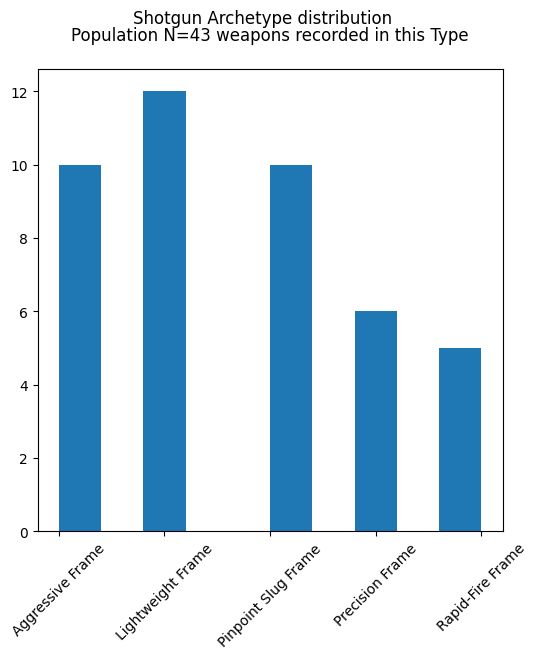

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


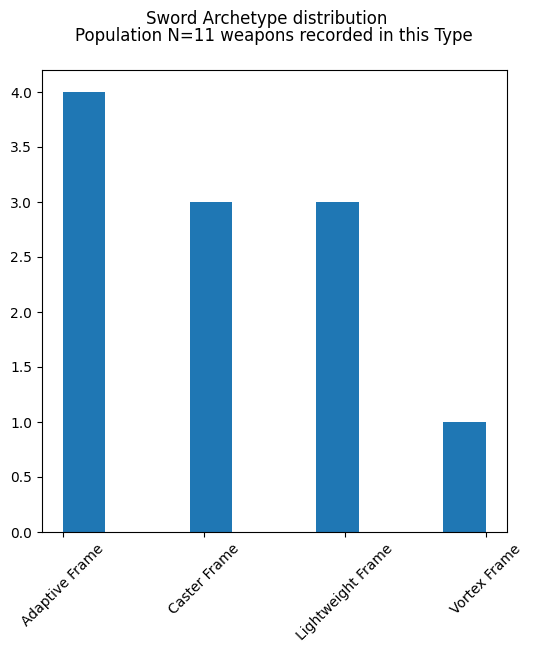

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


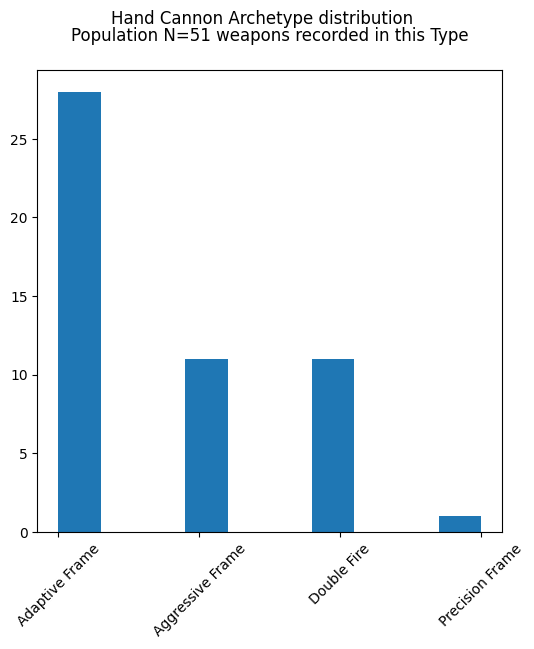

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


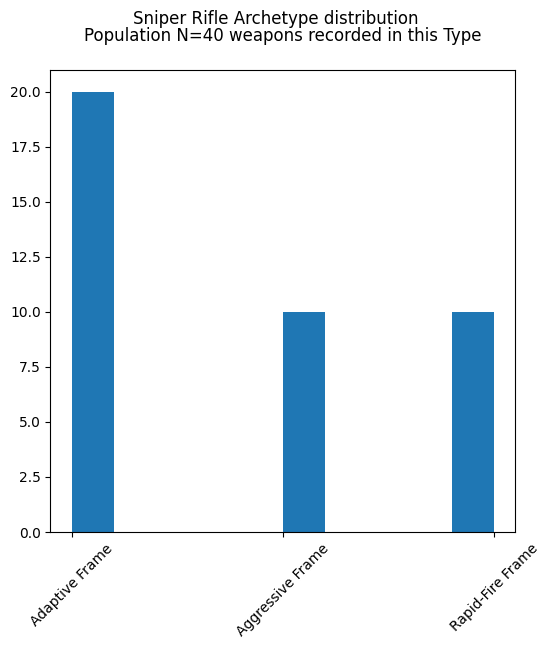

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


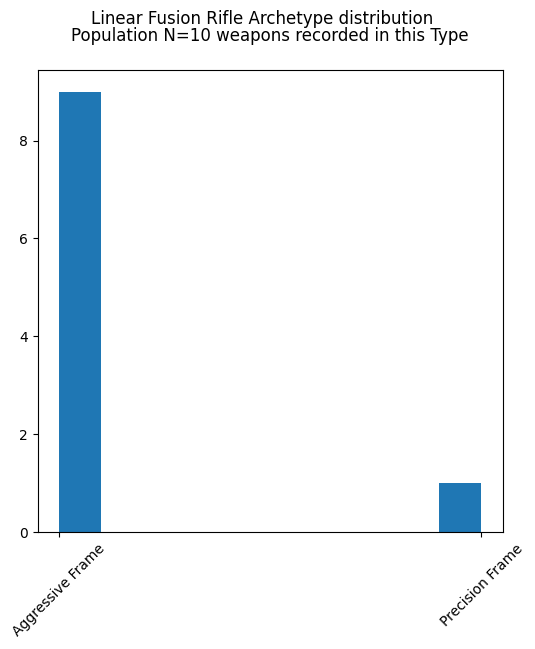

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


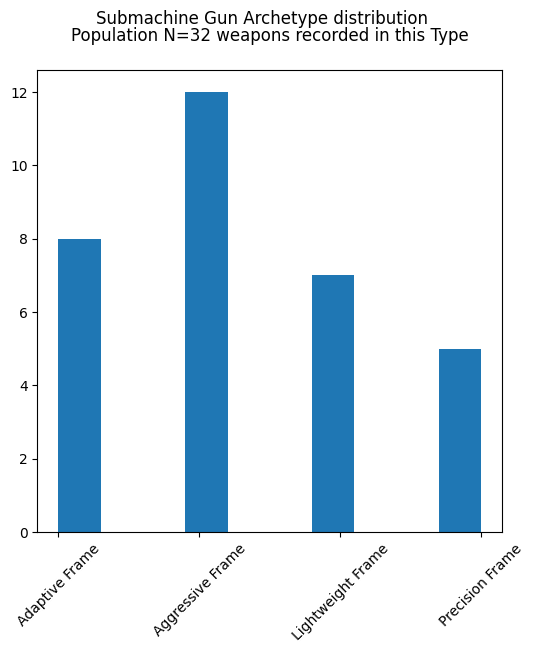

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


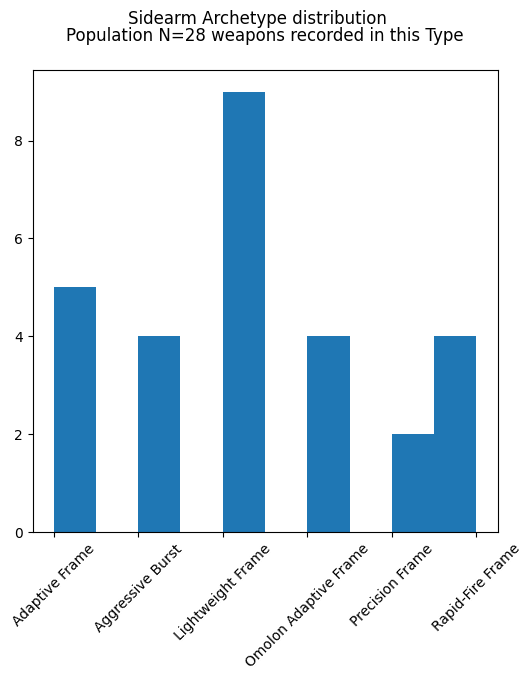

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


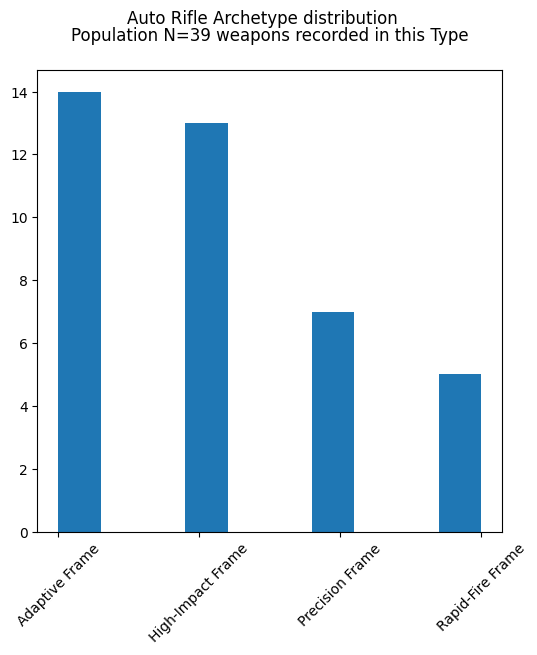

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


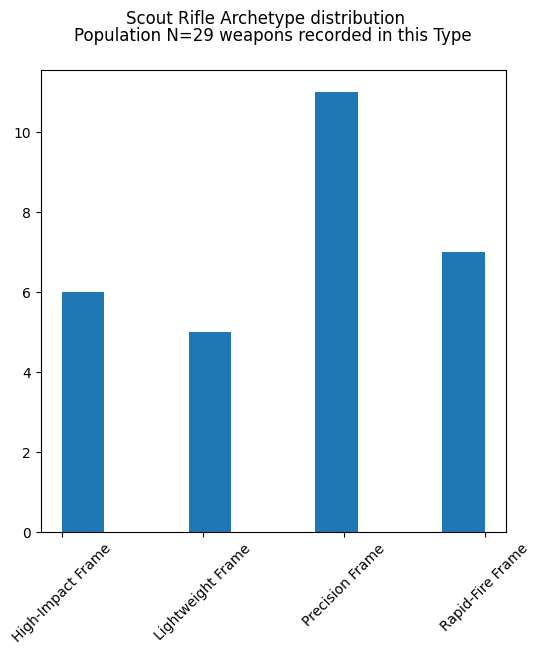

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


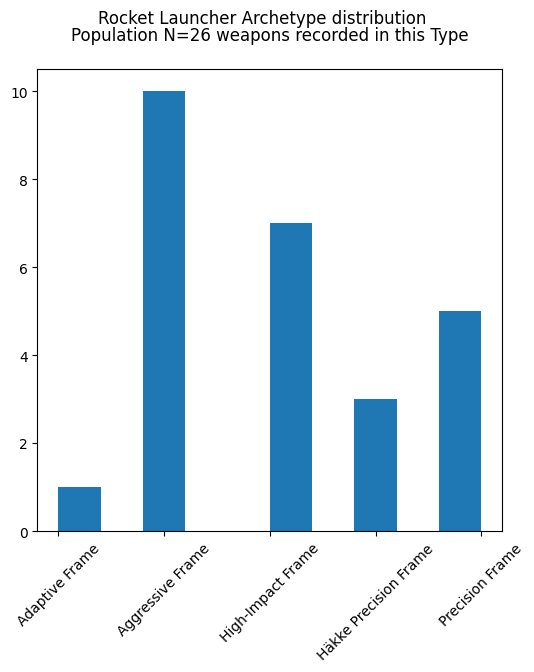

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


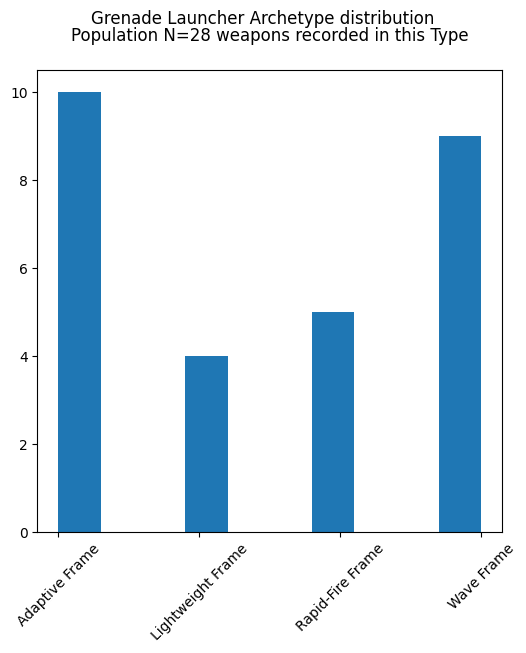

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


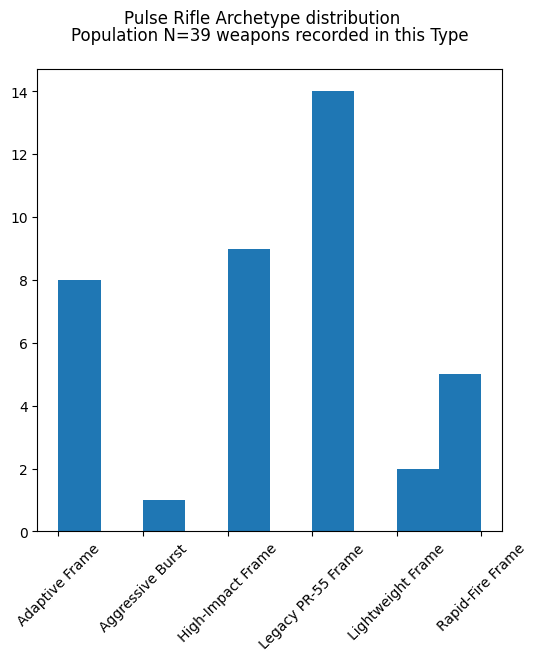

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


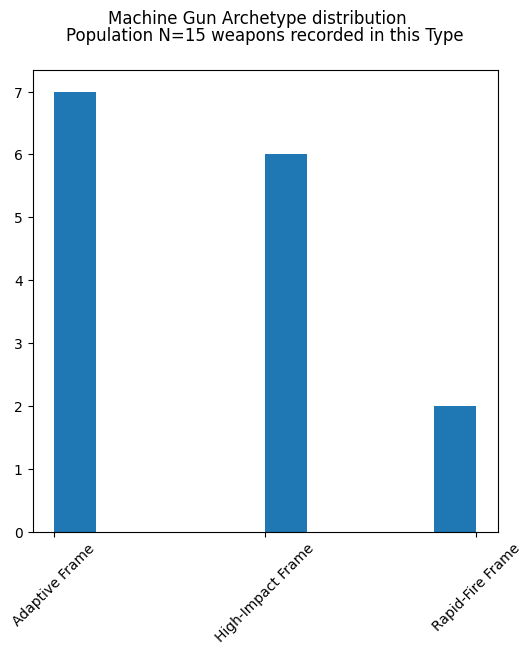

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


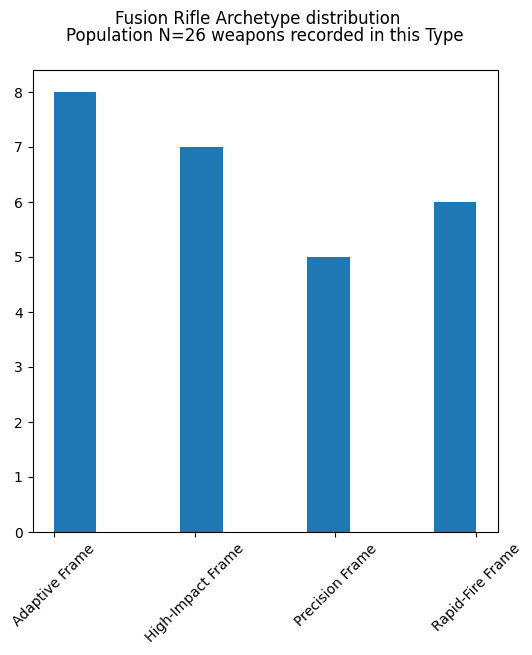

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


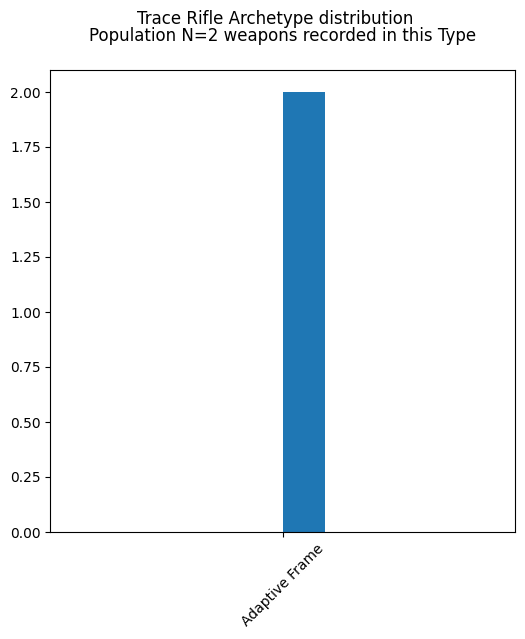

/tmp/ipykernel_18691/1888565852.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))


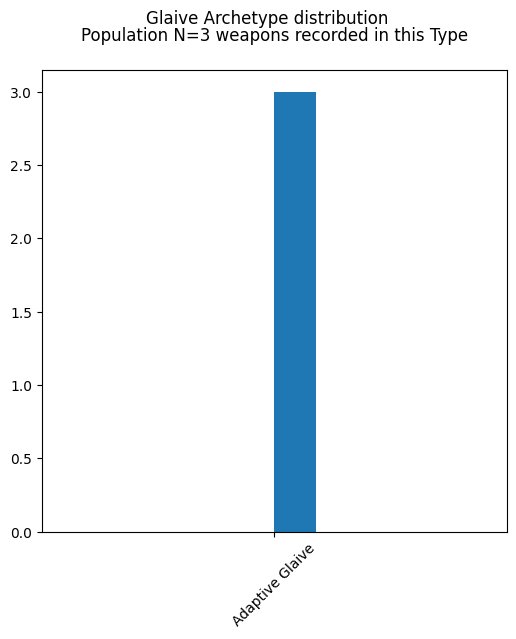

In [82]:

plt.suptitle('Overall Weapon Type usage')
plt.title('Population N={} games\n'.format(len(gameSet)))
weapon_type_counter = Counter(df['Weapon Type'])
plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%.2f%%', pctdistance=1.2, labeldistance=1.35)
plt.show()


for slot in df['Slot'].unique():
    subset_by_slot = df.loc[df['Slot'] == slot]
    weapon_type_counter = Counter(subset_by_slot['Weapon Type'])
    plt.suptitle('{} Slot Weapon Type usage'.format(slot))
    plt.title('Population N={} unique weapons across {} games\n'.format(len(subset_by_slot), len(gameSet)))
    plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys(), autopct='%.2f%%', pctdistance=1.2, labeldistance=1.35)
    plt.show()

for weaponType in df['Weapon Type'].unique():
    subset_by_slot = df.loc[df['Weapon Type'] == weaponType]
    plt.suptitle('{} Archetype distribution'.format(weaponType))
    plt.title('Population N={} weapons recorded in this Type\n'.format(len(subset_by_slot)))
    plt.gca().set_xticklabels(rotation=45, labels=np.unique(subset_by_slot['Archetype']))
    plt.hist(subset_by_slot['Archetype'], align='mid')
    plt.show()


#### Stat distributions 

In [6]:
print('Stat Means:----------------------------\n')
print(df.mean(numeric_only=True))
print('\nStat Skews:--------------------------\n')
print(df.skew(numeric_only=True))
print('\nStat Standard Deviation--------------\n')
print(df.std(numeric_only=True))

Stat Means:----------------------------

Stability                  40.565217
Handling                   44.178654
Range                      45.146739
Aim Assistance             61.055684
Airborne Effectiveness      9.551471
Recoil Direction           72.091121
Zoom                       17.931663
Magazine Size              18.161137
Impact                     55.744845
Reload Speed               40.431555
Rounds Per Minute         282.472000
Draw Time                 632.400000
Accuracy                   49.850000
Charge Time               382.442857
Velocity                   52.250000
Blast Radius               62.407407
Shield Duration            42.333333
Guard Resistance            0.000000
Guard Efficiency            0.000000
Swing Speed                43.636364
Charge Rate                28.636364
Ocurrences                 33.936652
Usage Rate in Slot (%)      0.678733
Global Usage Rate (%)       0.226244
dtype: float64

Stat Skews:--------------------------

Stability       

In [175]:
df
X = df.values[:,5:-2]
Y = df.values[:,-1]

from sklearn import model_selection
Xtr, Xts, Ytr, Yts = model_selection.train_test_split(X, Y, test_size=0.4, random_state=7)

In [176]:
from sklearn import ensemble
from sklearn import tree
from sklearn import svm
from sklearn.decomposition import PCA

model = tree.DecisionTreeRegressor()
model = ensemble.RandomForestRegressor()
#model = svm.SVR()


model.fit(Xtr, Ytr)
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [177]:


from sklearn.metrics import mean_squared_error, mean_absolute_error



tr_mse = mean_squared_error(Ytr, model.predict(Xtr))
tr_mae = mean_absolute_error(Ytr, model.predict(Xtr))

ts_mse = mean_squared_error(Yts, model.predict(Xts))
ts_mae = mean_absolute_error(Yts, model.predict(Xts))

from math import sqrt


print("Model training mse = ",tr_mse," & mae = ",tr_mae," & rmse = ", sqrt(tr_mse))
print("Model testing mse = ",ts_mse," & mae = ",ts_mae," & rmse = ", sqrt(ts_mse))


candidate = df.loc[ df['Name'] == 'Strident Whistle' ].values

xht, yht = candidate[:, 5:-2], candidate[:,-1]
print(yht, model.predict(xht))

Model training mse =  0.001359847882599568  & mae =  0.0057911949685534375  & rmse =  0.0368761153404147
Model testing mse =  0.04243208328939114  & mae =  0.030113370998116794  & rmse =  0.20599049320148524
[0.13999999999999999] [0.1386]


# Research

https://ieeexplore.ieee.org/abstract/document/8490456

https://eprints.whiterose.ac.uk/134035/1/controlling_crucible_destiny.pdf

https://dynresmanagement.com/uploads/3/5/2/7/35274584/guns-guardians-comparative.pdf